# Fraud Forecasting Analysis with ARIMA Models

This notebook performs comprehensive ARIMA model testing and selection for fraud trend prediction.

## Objectives:
1. Test multiple ARIMA model configurations
2. Compare model performance using validation metrics
3. Select the best performing model
4. Generate fraud trend forecasts
5. Analyze model accuracy and reliability

## Models to Test:
- Basic ARIMA (1,1,1), (1,1,2), (2,1,1)
- Seasonal ARIMA variations
- High-order ARIMA models
- Simple ARIMA configurations


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Import our custom predictor
import sys
sys.path.append('../backend')
from core.fraud_predictor import FraudPredictor
from data.database import DatabaseManager

print("📊 Fraud Forecasting Analysis Setup Complete!")


📊 Fraud Forecasting Analysis Setup Complete!


## 1. Load and Prepare Data


In [20]:
# Load fraud data from database container
print("📊 Loading fraud data from database container...")

try:
    # Initialize database manager with correct paths
    db_manager = DatabaseManager(
        data_dir="../dataset",  # Correct path to dataset
        db_path="../fraud_data.db"
    )
    
    # Connect to database
    if not db_manager.connect():
        print("❌ Failed to connect to database")
        data = None
    else:
        print("✅ Connected to database")
        
        # Load CSV data into database
        if not db_manager.load_csv_data():
            print("❌ Failed to load CSV data")
            data = None
        else:
            print("✅ CSV data loaded")
            
            # Load recent data for forecasting
            query = """
            SELECT trans_date_trans_time, is_fraud, amt, merchant, category
            FROM transactions 
            ORDER BY trans_date_trans_time
            LIMIT 50000
            """
            
            success, data, error = db_manager.execute_query(query)
            
            if success and data is not None:
                print(f"✅ Loaded {len(data)} transactions")
                print(f"Date range: {data['trans_date_trans_time'].min()} to {data['trans_date_trans_time'].max()}")
                
                # Basic data info
                print(f"\nData shape: {data.shape}")
                print(f"Fraud rate: {data['is_fraud'].mean():.4f}")
                print(f"Columns: {list(data.columns)}")
                
            else:
                print(f"❌ Failed to load data: {error}")
                data = None
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    data = None


INFO:data.database:Connected to database: ../fraud_data.db


📊 Loading fraud data from database container...
✅ Connected to database


INFO:data.database:Loaded 1296675 training records
INFO:data.database:Loaded 555719 test records
ERROR:data.database:Failed to create indexes: no such column: trans_date
INFO:data.database:CSV data loaded successfully


✅ CSV data loaded

=== DATABASE EXECUTION DEBUG ===
SQL Query: 
            SELECT trans_date_trans_time, is_fraud, amt, merchant, category
            FROM transactions 
            ORDER BY trans_date_trans_time
            LIMIT 50000
            
Parameters: None


INFO:data.database:Query executed successfully, returned 50000 rows


Query executed successfully, returned 50000 rows
Data preview: {'trans_date_trans_time': {0: '2020-06-21 12:14:25', 1: '2020-06-21 12:14:33', 2: '2020-06-21 12:14:53', 3: '2020-06-21 12:15:15', 4: '2020-06-21 12:15:17'}, 'is_fraud': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'amt': {0: 2.86, 1: 29.84, 2: 41.28, 3: 60.05, 4: 3.19}, 'merchant': {0: 'fraud_Kirlin and Sons', 1: 'fraud_Sporer-Keebler', 2: 'fraud_Swaniawski, Nitzsche and Welch', 3: 'fraud_Haley Group', 4: 'fraud_Johnston-Casper'}, 'category': {0: 'personal_care', 1: 'personal_care', 2: 'health_fitness', 3: 'misc_pos', 4: 'travel'}}
=== END DATABASE EXECUTION DEBUG ===

✅ Loaded 50000 transactions
Date range: 2020-06-21 12:14:25 to 2020-07-07 23:23:37

Data shape: (50000, 5)
Fraud rate: 0.0040
Columns: ['trans_date_trans_time', 'is_fraud', 'amt', 'merchant', 'category']


## 2. Prepare Time Series Data


🔄 Preparing time series data...
✅ Time series data prepared: 17 days
Date range: 2020-06-21 00:00:00 to 2020-07-07 00:00:00

Time Series Statistics:
Mean fraud rate: 0.0040
Std fraud rate: 0.0025
Min fraud rate: 0.0000
Max fraud rate: 0.0098


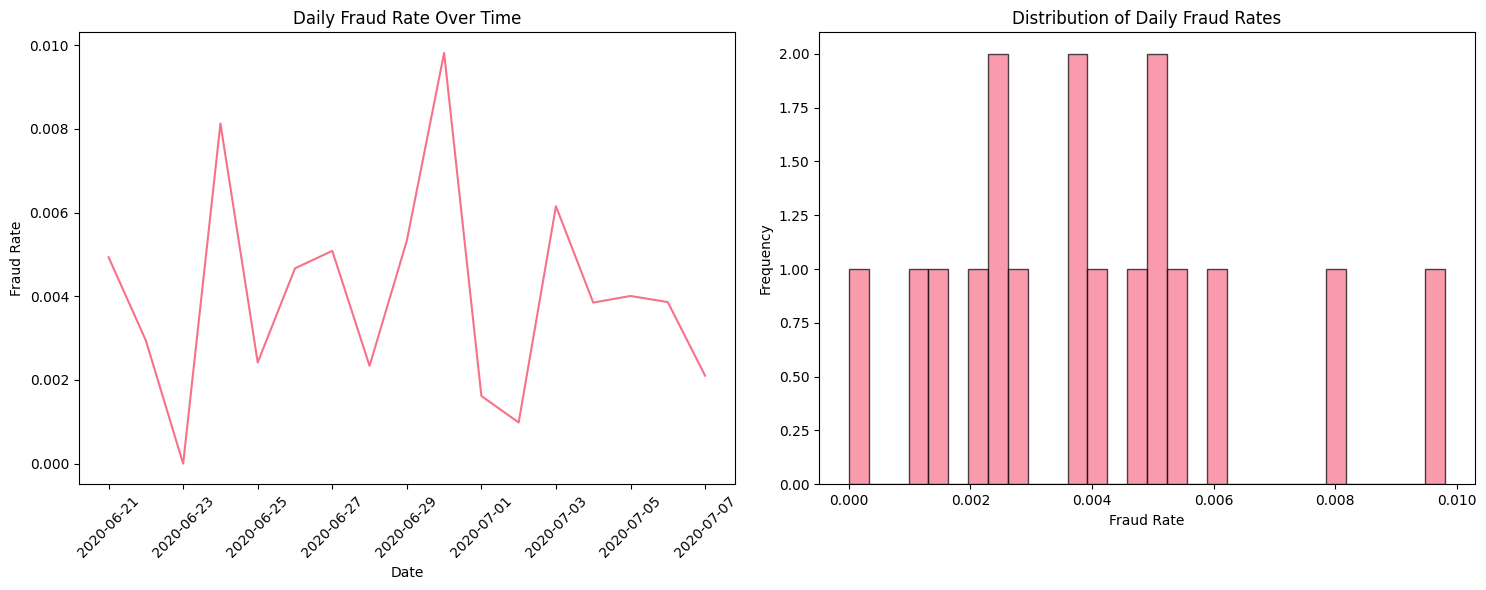


🔍 Testing stationarity...
ADF Statistic: -2.3957
P-value: 0.1430
Stationary: False
Interpretation: Non-stationary


In [21]:
if data is not None:
    # Initialize predictor
    predictor = FraudPredictor()
    
    # Prepare time series data
    print("🔄 Preparing time series data...")
    ts_data = predictor.prepare_time_series_data(data, 'is_fraud')
    
    if not ts_data.empty:
        print(f"✅ Time series data prepared: {len(ts_data)} days")
        print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
        
        # Display basic statistics
        print(f"\nTime Series Statistics:")
        print(f"Mean fraud rate: {ts_data['fraud_rate'].mean():.4f}")
        print(f"Std fraud rate: {ts_data['fraud_rate'].std():.4f}")
        print(f"Min fraud rate: {ts_data['fraud_rate'].min():.4f}")
        print(f"Max fraud rate: {ts_data['fraud_rate'].max():.4f}")
        
        # Plot time series
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.plot(ts_data.index, ts_data['fraud_rate'])
        plt.title('Daily Fraud Rate Over Time')
        plt.xlabel('Date')
        plt.ylabel('Fraud Rate')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        plt.hist(ts_data['fraud_rate'], bins=30, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Daily Fraud Rates')
        plt.xlabel('Fraud Rate')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        # Test stationarity
        print(f"\n🔍 Testing stationarity...")
        stationarity = predictor.test_stationarity(ts_data['fraud_rate'])
        
        if 'error' not in stationarity:
            print(f"ADF Statistic: {stationarity['adf_statistic']:.4f}")
            print(f"P-value: {stationarity['p_value']:.4f}")
            print(f"Stationary: {stationarity['is_stationary']}")
            print(f"Interpretation: {stationarity['interpretation']}")
        else:
            print(f"❌ Stationarity test failed: {stationarity['error']}")
            
    else:
        print("❌ Failed to prepare time series data")
        ts_data = None
else:
    print("❌ No data available for time series preparation")
    ts_data = None


## 3. Test Multiple ARIMA Models


In [22]:
if ts_data is not None:
    print("🧪 Testing multiple ARIMA models...")
    
    # Define different model configurations to test
    model_configs = [
        {
            "name": "Basic ARIMA",
            "orders": [(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2)]
        },
        {
            "name": "Simple ARIMA", 
            "orders": [(0, 1, 1), (1, 0, 1), (0, 1, 2), (1, 0, 2)]
        },
        {
            "name": "High Order ARIMA",
            "orders": [(2, 2, 1), (2, 2, 2), (3, 1, 2), (3, 2, 1)]
        },
        {
            "name": "Seasonal ARIMA",
            "orders": [(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2)]
        }
    ]
    
    all_results = {}
    
    for config in model_configs:
        print(f"\n📈 Testing {config['name']}...")
        
        try:
            # Test models for this configuration
            result = predictor.test_multiple_models(
                ts_data['fraud_rate'], 
                model_orders=config['orders']
            )
            
            if result.get("success", False):
                all_results[config['name']] = result
                print(f"✅ {config['name']} completed")
                print(f"   Best order: {result['best_params']}")
                print(f"   Best AIC: {result['best_aic']:.2f}")
                print(f"   Models tested: {result['total_models_tested']}")
            else:
                print(f"❌ {config['name']} failed: {result.get('error', 'Unknown error')}")
                
        except Exception as e:
            print(f"❌ {config['name']} failed with exception: {e}")
            continue
    
    print(f"\n📊 Model Testing Summary:")
    print(f"Total configurations tested: {len(model_configs)}")
    print(f"Successful configurations: {len(all_results)}")
    
else:
    print("❌ No time series data available for model testing")
    all_results = {}


ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'


🧪 Testing multiple ARIMA models...

📈 Testing Basic ARIMA...


ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'


✅ Basic ARIMA completed
   Best order: (2, 1, 2)
   Best AIC: -137.18
   Models tested: 4

📈 Testing Simple ARIMA...


ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'


✅ Simple ARIMA completed
   Best order: (1, 0, 2)
   Best AIC: -153.53
   Models tested: 4

📈 Testing High Order ARIMA...


ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'
ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'


✅ High Order ARIMA completed
   Best order: (3, 1, 2)
   Best AIC: -131.07
   Models tested: 4

📈 Testing Seasonal ARIMA...


ERROR:core.fraud_predictor:Error validating model: 'ARIMAResults' object has no attribute 'order'


✅ Seasonal ARIMA completed
   Best order: (2, 1, 2)
   Best AIC: -137.18
   Models tested: 4

📊 Model Testing Summary:
Total configurations tested: 4
Successful configurations: 4
